In [2]:
using LinearAlgebra
using Statistics
using Plots
using StatsPlots
using BenchmarkTools

In [8]:
# helper methods
function symmetric_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim,dim);
    for i = 1:dim
        for j = 1:i
            A[i,j] = rand(1:50);
            A[j,i] = A[i,j];
        end
    end
    if show_matrix
        display(A);
    end
    return A;
end

# we might change it to just rand(dim,dim)
function random_matrix(dim::Integer, show_matrix::Bool=false)::Matrix
    A = ones(dim, dim);
    for i = 1:dim
        for j = 1:dim
            A[i,j] = rand(1:50);
        end
    end
    if show_matrix
        display(A);
    end
    return A
end

function diagonal_matrix(dim::Integer)::Matrix
    Diag = ones(dim,dim)
    return Diagonal(Diag)
end

function eye(dim::Integer)::Matrix
    return Matrix{Float64}(I,dim,dim);
end


function custom_cond(λₘₐₓ, λₘᵢₙ)
    return sqrt(λₘₐₓ/λₘᵢₙ)
end

function get_diag(A::Matrix)::Array #get diagonal as vector
    dim = size(A,1)
    diag = Array{Float64}(undef, dim)
    for i=1:dim
        diag[i] = A[i,i]
    end
    return diag
end

get_diag (generic function with 1 method)

# Metoda potęgowa

Poniżej przygotowana jest funkcja do metody iteracji prostej (metoda potęgowa), dzięki której można wyznaczyć największą co do modułu wartość własną, czyli promień spektralny macierzy, który opisany jest wzorem:
## $$\rho(A) = |\lambda_{max}| = \lim_{i \to \infty} \frac{||t_{i+1}||_{\infty}}{||t_{i}||_{\infty}}$$

Przy założeniu, że dowolny wektor początkowy t_{0} != 0, do uzyskania promienia spektralnego prowadzą iteracje postaci:
## $$t_{i+1} = At_{i},\ i=0,1,2...$$



In [4]:
function power_eigen(A::Matrix, iterations::Integer)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    results = Float64[];
    eig = nothing;
    x1 = x;
    
    for i = 1:iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        eig = x' * A * x1 / (x' * x1);
        push!(results, eig[1]);
    end
    return eig, results;
end

function power_eigen_min(A::Matrix, iterations::Integer)::Array
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    for i = 1:iterations
        x1 = x;
        x = A \ x;
        x = x / norm(x);
    end

    return x' * A * x1 / (x' * x1);
end

function power_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-6)::Tuple{Array, Array}
    n = size(A, 1);
    x = ones(n,1);
    x1 = x;
    eig = nothing
    
    for i = 1:max_iterations
        x1 = x;
        x = A * x;
        x = x / norm(x);
        
        new_eig = x' * A * x1 / (x' * x1)

        if eig != nothing && abs(new_eig[1] - eig) < error
            return new_eig, x
        end
        eig = new_eig[1]
    end
    return eig, x
end

power_eigen_stop (generic function with 3 methods)

In [5]:
A = symmetric_matrix(5);
#A = random_matrix(5);
#A = [22 21 -8 4; 21 49 11 39; -8 11 60 -19; 4 39 -19 135]
λₘₐₓ, _ = power_eigen(A, 20);
λₘᵢₙ = power_eigen_min(A,20);
display(λₘₐₓ);
display(λₘᵢₙ);
e, v = eigen(A);
display(e);
display(v)
e, v = power_eigen_stop(A)
display(e)
display(v)

1×1 Array{Float64,2}:
 152.96686851905852

1×1 Array{Float64,2}:
 0.8348339747988809

5-element Array{Float64,1}:
 -34.316878007170466
  -9.65776887352332
   0.8348339747988547
  39.17294438683627
 152.9668685190583

5×5 Array{Float64,2}:
 -0.326756   -0.297776   0.647696  -0.347353   -0.514194
 -0.6565      0.189655  -0.60818   -0.0995824  -0.391457
  0.644774   -0.139187  -0.360378  -0.461141   -0.471561
  0.0192578  -0.69815   -0.174891   0.642527   -0.262275
  0.214786    0.607103   0.223937   0.4939     -0.539637

1×1 Array{Float64,2}:
 152.96686849516976

5×1 Array{Float64,2}:
 0.5141909530707414
 0.39145554632374147
 0.4715582436025391
 0.26228008283302345
 0.5396408065298385

In [6]:
# benchmark time for above Matrix
@btime  power_eigen(A, 20); # λₘₐₓ
@btime  power_eigen_min(A,20); # λₘᵢₙ

  19.599 μs (168 allocations: 17.67 KiB)
  16.200 μs (87 allocations: 13.84 KiB)


Jak widać z wyniku wykonania powyższego kodu, uzyskaliśmy największą co do modułu wartość własną macierzy. Ta wartość zgadza się z wartością otrzymaną za pomocą metody eigen(A). Za pomocą metody potęgowej można również wyznaczyć najmniejszą co do modułu wartość własną macierzy. Korzysta się z twierdzenia dotyczącego przesunięcia spektrum macierzy:<br />
### "Jeżeli $\lambda$ jest wartością własną macierzy A, to $\lambda + r$ jest wartością własną macierzy $A + \tau I$"
Należy pamiętać, że twierdzenie ma zastosowanie dla macierzy symetrycznych i dodatnio określonych. Po zastosowaniu przesunięcia $B = A - \lambda_{max}I$ można ponownie zastosować metodę iteracji prostej dla macierzy B zbieżną do największej co do modułu wartości własnej $\lambda = \lambda_{min}-\lambda_{max}$. Stąd można wyznaczyć $\lambda_{min}$.

In [7]:
B = A' * A;
λₘₐₓ, _ = power_eigen(B, 50);
n = size(A,1);
B_min = B - λₘₐₓ .* eye(n);
lambda_dash, _ = power_eigen(B_min, 50);
λₘᵢₙ = lambda_dash + λₘₐₓ;

Mając największą i najmniejszą wartość własną macierzy, można wyznaczyć współczynnik uwarunkowania macierzy:
$$cond(A)=\sqrt{\frac{\lambda_{max}(A^TA)}{\lambda_{min}(A^TA)}}$$
We wzorze przyjęto, że macierz A jest symetryczna, co oznacza, że $A=A^T$, ewentualnie można macierz wejściową doprowadzić do postaci symetrycznej stosując wzór $B = A^TA$

In [8]:
value = custom_cond(λₘₐₓ, λₘᵢₙ)
print(value)

cond(A)

[21.818760336899]

183.23028666377522

# Metoda Jacobiego

In [49]:
function jacobi_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix, Array}
    n = size(A,1);
    results = Float64[];
    for i = 1:iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R; 
        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
        
    end
    return A, results
end

function jacobi_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Tuple{Array, Matrix}
    n = size(A,1);
    eigs = nothing
    eigenVectors = eye(n)
    for i = 1:max_iterations
        s,t = maxst(A);
        
        d = √((A[s,s] - A[t,t])^2 + 4 * A[s,t]^2);
        sin2t = 2 * A[s,t] / d;
        cos2t = (A[s,s] - A[t,t]) / d;
        dt = sqrt(2 * (1 + cos2t));
        sint = abs(sin2t) / dt;
        cost = abs((1 + cos2t) / dt);
        cost = sign(A[s,t]) * cost;

        R = eye(n);
        R[s,s] = cost;
        R[t,t] = cost;
        R[s,t] = -sint;
        R[t,s] = sint;
        
        A = R' * A * R;
        
        new_eigs = get_diag(A)
        eigenVectors = eigenVectors*R
        if eigs != nothing && !any(broadcast(abs, new_eigs .- eigs) .> error)
            return new_eigs, eigenVectors
        end
        eigs = new_eigs
        
    end
    return eigs, eigenVectors
end

function maxst(A::Matrix)::Tuple{Integer,Integer}
    s = 1;
    t = 2;
    n = size(A,1);
    for c = 2:n
        for r = 1:c-1
            if abs(A[r,c]) > abs(A[s,t])
                s = r;
                t = c;
            end
        end
    end
    return s, t
end

maxst (generic function with 1 method)

In [45]:
#F = [12 6 -6 1; 6 16 2 100; -6 2 16 1 ;1 100 1 4];
#F = rand(4,4);
F = symmetric_matrix(10,true);
FJ, _ = jacobi_eigen(F, 15);

n = size(FJ,1);
FJ = Diagonal(FJ);

#display(FJ)
e,v = eigen(F);
display(e)
display(v)
e,v = jacobi_eigen_stop(F)
display(e)
display(v)


10×10 Array{Float64,2}:
 38.0  38.0   9.0   7.0  19.0  26.0  13.0  13.0  25.0  45.0
 38.0  17.0  27.0  15.0  25.0  45.0  44.0  16.0  18.0  34.0
  9.0  27.0  17.0  30.0  29.0   5.0  28.0  32.0  34.0   9.0
  7.0  15.0  30.0  39.0   7.0  12.0  26.0  35.0  18.0  27.0
 19.0  25.0  29.0   7.0  42.0  32.0  10.0  15.0  20.0  23.0
 26.0  45.0   5.0  12.0  32.0  23.0  38.0  46.0  26.0  39.0
 13.0  44.0  28.0  26.0  10.0  38.0  50.0  36.0  47.0  43.0
 13.0  16.0  32.0  35.0  15.0  46.0  36.0  40.0  12.0  30.0
 25.0  18.0  34.0  18.0  20.0  26.0  47.0  12.0  47.0  43.0
 45.0  34.0   9.0  27.0  23.0  39.0  43.0  30.0  43.0  32.0

10-element Array{Float64,1}:
 -50.06152998366363
 -30.15990117243575
 -19.410888292795303
  -1.8891519044989877
   6.774067744151772
  23.708551522411526
  37.11838877114107
  41.90567404752632
  61.102682694703375
 275.9121065734594

10×10 Array{Float64,2}:
 -0.105551    -0.424368    0.0891589  …  -0.0137609   0.520673   -0.272478
  0.511405     0.331937   -0.285485       0.078014    0.204188   -0.324586
 -0.460675     0.33646     0.0634285      0.0972376  -0.29683    -0.246229
  0.00244465  -0.202479   -0.233719       0.057602   -0.528674   -0.244345
  0.128936    -0.217796    0.234796       0.548022    0.250013   -0.24573
 -0.514909    -0.0296021  -0.553768   …   0.245143    0.150727   -0.344608
 -0.109546    -0.395798    0.408862      -0.371515   -0.202501   -0.400111
  0.375014    -0.0222855   0.147608       0.385019   -0.390726   -0.316207
  0.261002    -0.0581086  -0.362193      -0.554266    0.0276675  -0.341708
 -0.112172     0.588801    0.412278      -0.164482    0.199847   -0.37959

10-element Array{Float64,1}:
 275.9071912021876
  61.096354650541585
  41.89505164753715
  37.092463942585304
  23.718732383065678
   6.773154254813222
  -1.8954894649982745
 -19.384610434213396
 -30.150524067430432
 -50.05232411408839

10×10 Array{Float64,2}:
 -0.272786   0.519906    0.0014981  …   0.0802022  -0.428602    0.10962
 -0.324217   0.206435    0.0793128     -0.29054     0.331889   -0.512696
 -0.247014  -0.292199    0.0869147      0.0409672   0.343216    0.460753
 -0.244943  -0.531381    0.0704283     -0.218404   -0.200837    0.00259059
 -0.243004   0.246421    0.533488       0.247398   -0.21312    -0.130414
 -0.346751   0.15108     0.246738   …  -0.544428   -0.0347418   0.511589
 -0.400677  -0.206967   -0.376621       0.411857   -0.39191     0.103889
 -0.314407  -0.388852    0.39235        0.139958   -0.0199517  -0.375201
 -0.341977   0.0285801  -0.560556      -0.365933   -0.0625827  -0.264133
 -0.379247   0.202311   -0.160308       0.423139    0.586074    0.11296

In [50]:
# benchmark time for above Matrix
@btime jacobi_eigen(F, 15);

  20.599 μs (65 allocations: 42.09 KiB)


# QR algorithm

In [56]:
function QR_eigen(A::Matrix, iterations::Integer)::Tuple{Matrix, Array}
    results = Float64[];
    for k = 1:iterations
        Q, R = mgs(A);
        A = R * Q;

        DA = Diagonal(A);
        val = maximum(abs, DA);
        push!(results, val);
    end
    return A, results;
end

function QR_eigen_stop(A::Matrix, max_iterations::Integer=1000, error::Float64=1e-2)::Tuple{Array, Matrix}
    eigs = nothing
    pQ = eye(size(A,1))
    for k = 1:max_iterations
        Q, R = mgs(A);
        A = R * Q;
        pQ = pQ * Q
        new_eigs = get_diag(A)
        if eigs != nothing && !any(x -> x > error, broadcast(abs, new_eigs .- eigs)) 
            return new_eigs, pQ
        end
        eigs = new_eigs
    end
    return eigs, pQ;
end

function mgs(A::Matrix)::Tuple{Matrix, Matrix}
    n = size(A,1);
    R = zeros(n,n);
    Q = zeros(n,n);
    for j = 1:n
        v = A[:,j];
        for i = 1:j-1
            R[i,j] = Q[:,i]' * v;
            v = v - R[i,j] * Q[:,i];
        end
        R[j,j] = norm(v);
        Q[:,j] = v / R[j,j];
    end

    return Q, R;
end

mgs (generic function with 1 method)

In [53]:
A = symmetric_matrix(5);
AQR, _ = QR_eigen(A, 30);
Diag = Diagonal(AQR);
display(Diag);

e, v = eigen(A);
display(e)
display(v)
e, v = QR_eigen_stop(A);
display(e)
display(v)

5×5 Diagonal{Float64,Array{Float64,1}}:
 184.494     ⋅         ⋅        ⋅        ⋅ 
    ⋅     -45.7634     ⋅        ⋅        ⋅ 
    ⋅        ⋅      -28.7881    ⋅        ⋅ 
    ⋅        ⋅         ⋅      24.1384    ⋅ 
    ⋅        ⋅         ⋅        ⋅      -1.08108

5-element Array{Float64,1}:
 -45.7634462738699
 -28.788128099827606
  -1.0810821770206402
  24.138434697178376
 184.49422185353956

5×5 Array{Float64,2}:
  0.48223      0.385711    0.477596  -0.459711  -0.423377
 -0.465112     0.666693   -0.332025   0.146149  -0.455621
 -0.39784     -0.403468    0.574723   0.306187  -0.504855
 -0.00434104  -0.490077   -0.517236  -0.497049  -0.495192
  0.626761    -0.0615188  -0.252628   0.653068  -0.336254

5-element Array{Float64,1}:
 184.49422185353964
 -45.76343802446337
 -28.766754259293727
  24.117052607238058
  -1.081082177020579

5×5 Array{Float64,2}:
 0.423377   0.481918     0.37669     0.467453   0.477596
 0.455621  -0.465501     0.66921    -0.132799  -0.332025
 0.504855  -0.397542    -0.397477   -0.314303   0.574723
 0.495192  -0.00411753  -0.499971    0.487098  -0.517236
 0.336254   0.626903    -0.0479954  -0.654065  -0.252628

In [57]:
@btime QR_eigen(A, 30);

  88.699 μs (1626 allocations: 217.20 KiB)


# Badania

Poniższe wykresy prezentują zbieżność tylko dla największych wartości własnych, ponieważ metoda potęgowa wyznacza tylko pojedynczą wartość.

In [15]:
function plot_eigenvalues(PlotA::Matrix, max_iterations::Integer, show_all_in_one::Bool=false, err::Bool=false)
    x = 1:max_iterations;
    e, v = eigen(PlotA);
    eigen_lambda = maximum(abs, e);
    if !err
        results_eig = zeros(0);
        for i = x
            append!(results_eig, eigen_lambda);
        end
    end

    #power method
    _, results_power = power_eigen(PlotA, max_iterations);
    if err
        results_power = broadcast(abs, results_power .- eigen_lambda);
        #results_power = abs.(results_power - eigen_lambda);
    end

    # jacobi algorithm
    _, results_jacobi = jacobi_eigen(PlotA, max_iterations);
    if err
        results_jacobi = broadcast(abs, results_jacobi .- eigen_lambda);
    end

    # QR algorithm
    _, results_qr = QR_eigen(PlotA, max_iterations);
    if err
        results_qr = broadcast(abs, results_qr .- eigen_lambda);
    end


    if err
        results = hcat(results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max error", label=["power" "jacobi" "QR"], xlabel="iteracje", ylabel="błąd lambda");
        results = results_power;
        plot_power = plot(x, results, title= "Lambda max error", label="power", xlabel="iteracje", ylabel="błąd lambda");
        results = results_jacobi;
        plot_jacobi = plot(x, results, title= "Lambda max error", label="jacobi", xlabel="iteracje", ylabel="błąd lambda");
        results = results_qr;
        plot_qr = plot(x, results, title= "Lambda max error", label="QR", xlabel="iteracje", ylabel="błąd lambda");
    else
        results = hcat(results_eig, results_power, results_jacobi, results_qr);
        plot_all = plot(x, results, title= "Lambda max", label=["eigen" "power" "jacobi" "QR"], xlabel="iteracje", ylabel="wartosc lambda", ylim=(eigen_lambda*0.25, eigen_lambda*1.2));
        results = hcat(results_eig, results_power);
        plot_power = plot(x, results, title= "Lambda max", label=["eigen" "power"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_jacobi);
        plot_jacobi = plot(x, results, title= "Lambda max", label=["eigen" "jacobi"], xlabel="iteracje", ylabel="wartosc lambda");
        results = hcat(results_eig, results_qr);
        plot_qr = plot(x, results, title= "Lambda max", label=["eigen" "QR"], xlabel="iteracje", ylabel="wartosc lambda");
    end
    if !show_all_in_one
        #show plots separate 
        display(plot_all);
        display(plot_power);
        display(plot_jacobi);
        display(plot_qr);
    else
        # all plots together
        all_plots = plot(plot_all, plot_power, plot_jacobi, plot_qr, size = (800,800), layout = grid(4, 1, heights=[0.25 , 0.25, 0.25, 0.25]));
        display(all_plots);
    end

end

plot_eigenvalues (generic function with 3 methods)

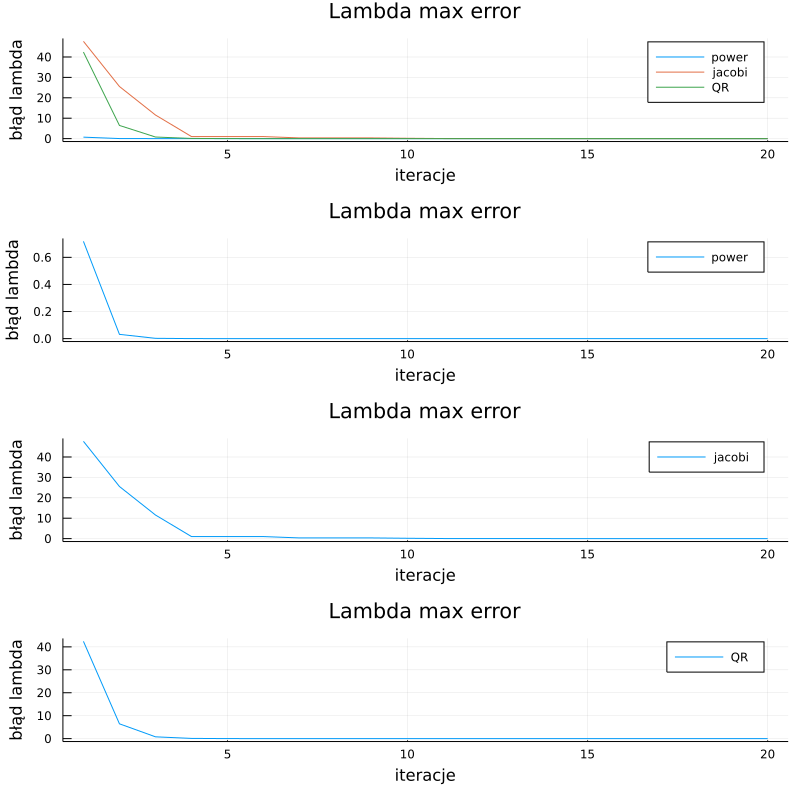

In [16]:
A = symmetric_matrix(5);
plot_eigenvalues(A, 20, true, true);

## Przypadki testowe

metoda potęgowa - macierze o elementach i wartościach własnych rzeczywistych<br />
metoda Jacobiego - macierze symetryczne (w tym hermitowskie)<br />
algorytm QR - macierze niesymetryczne

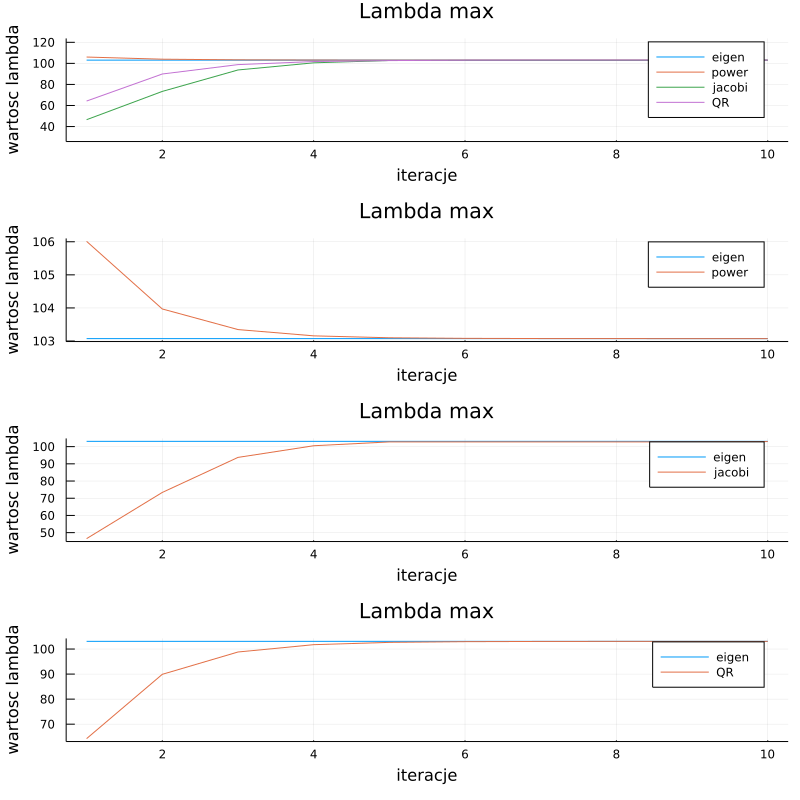

  0.203775 seconds (198.43 k allocations: 9.380 MiB)


In [17]:
Test1 = symmetric_matrix(5)
@time plot_eigenvalues(Test1, 10, true)

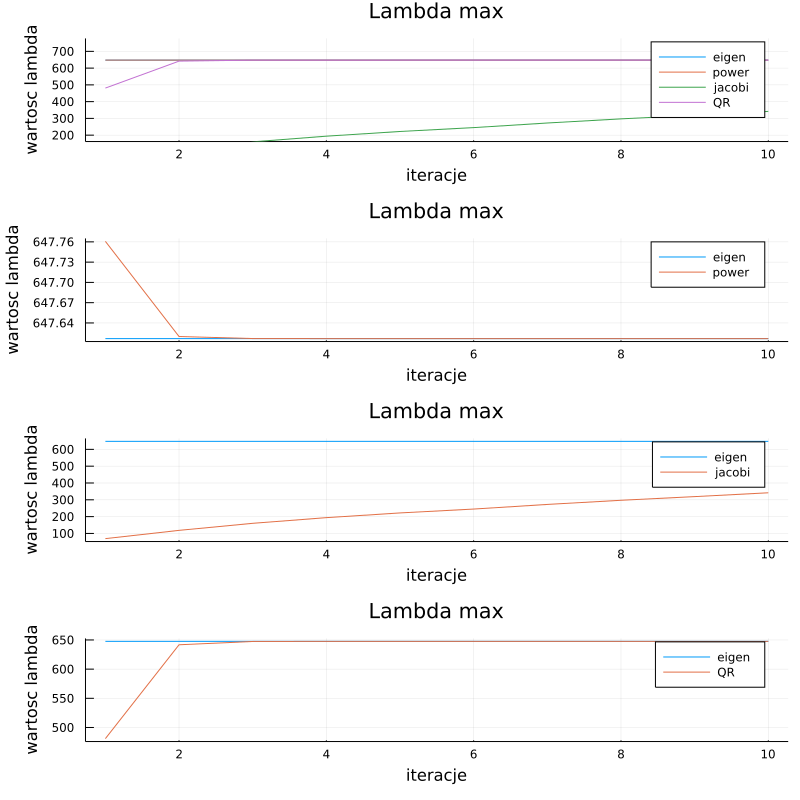

  0.073421 seconds (128.43 k allocations: 8.788 MiB)


In [18]:
Test2 = symmetric_matrix(25)
@time plot_eigenvalues(Test2, 10, true)

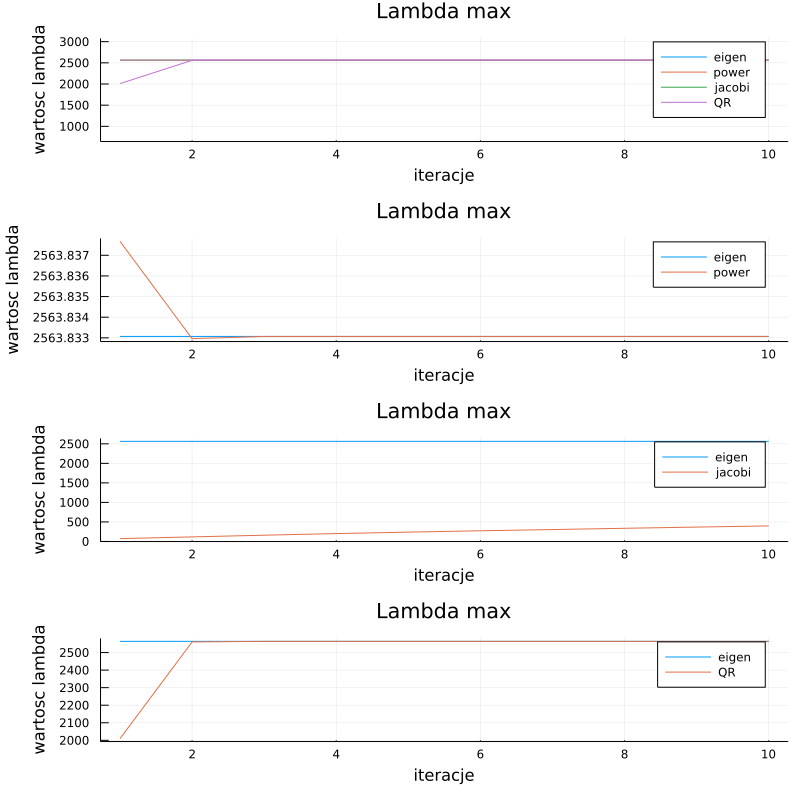

  0.311460 seconds (315.65 k allocations: 181.574 MiB, 20.90% gc time)


In [19]:
Test3 = symmetric_matrix(100)
@time plot_eigenvalues(Test3, 10, true)

Benchmarki dla wszystkich metod przy 3 rozmiarach macierzy:

In [20]:
A = symmetric_matrix(10)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   7.450 μs (50 allocations: 5.81 KiB)
  138.501 μs (934 allocations: 402.78 KiB)


In [21]:
A = symmetric_matrix(25)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   11.800 μs (50 allocations: 8.19 KiB)
Jacobi:   2.893 ms (3718 allocations: 8.06 MiB)


In [22]:
A = symmetric_matrix(100)
print("Power: ")
@btime power_eigen_stop(A)
print("QR: ")
@btime QR_eigen_stop(A)
print("Jacobi: ")
@btime jacobi_eigen_stop(A);

Power:   60.099 μs (34 allocations: 13.28 KiB)
QR: 16.79 GiB)
Jacobi:   341.077 ms (16999 allocations: 385.50 MiB)


In [23]:
A = symmetric_matrix(100)
@benchmark QR_eigen_stop(A)

BenchmarkTools.Trial: 
  memory estimate:  16.99 GiB
  allocs estimate:  20011005
  --------------
  minimum time:     5.312 s (15.66% GC)
  median time:      5.312 s (15.66% GC)
  mean time:        5.312 s (15.66% GC)
  maximum time:     5.312 s (15.66% GC)
  --------------
  samples:          1
  evals/sample:     1

In [24]:
# plot time benchmarks
#plot for [x1, x2, x3...] iterations
# plot_mean_time(A, [5, 10]);
function plot_mean_time(A::Matrix, iterations::Array, sample::Integer=2000)

    n = size(iterations,1);
    results = zeros(1);
    nam = [];

    for i = 1:n
        power = @benchmark  power_eigen(A, $iterations[$i]) samples = sample;
        power = mean(power.times)/1000;
        jacobi = @benchmark jacobi_eigen(A, $iterations[$i]) samples = sample;
        jacobi = mean(jacobi.times)/1000;
        qr = @benchmark QR_eigen(A, $iterations[$i]) samples = sample;
        qr = mean(qr.times)/1000;
        results = hcat(results, power, jacobi, qr);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
        push!(nam, iterations[i]);
    end
    results = results[2:end];
    ctg = repeat(["Power", "Jacobi", "QR"], outer = n)
    
    plot_time = groupedbar(nam, results, group = ctg, xlabel = "Liczba iteracji", ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod dla okreśłonej liczby iteracji", bar_width = 0.67,
        lw = 0, framestyle = :box)
    display(plot_time);
    
end

# plot to reach stop condition
function plot_mean_time(A::Matrix, sample::Integer=5000)
    power = @benchmark  power_eigen_stop(A) samples = sample;
    power = mean(power.times)/1000;
    jacobi = @benchmark jacobi_eigen_stop(A) samples = sample;
    jacobi = mean(jacobi.times)/1000;
    qr = @benchmark QR_eigen_stop(A) samples = sample;
    qr = mean(qr.times)/1000;

    results = [power, jacobi, qr];
    nam = repeat(["time"], inner=3);
    ctg = repeat(["Power", "Jacobi", "QR"], outer = 1)

    display(results);

    plot_time = groupedbar(nam, results, group = ctg, ylabel = "Średni czas [µs]",
        title = "Czas wykonania metod do warunku stopu", bar_width = 0.67,
        lw = 0, framestyle = :box);
    display(plot_time);
end

plot_mean_time (generic function with 4 methods)

3-element Array{Float64,1}:
  8.546693733333333
 33.562230799999995
 88.7044686

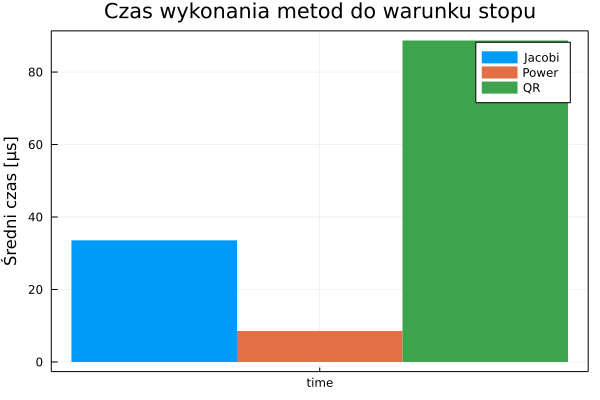

In [25]:
A = symmetric_matrix(5);
plot_mean_time(A);

# Zastosowanie

In [26]:
X = [sin.(pi * (1:6)/2) cos.(pi * (1:6)/4) rand(6,10)]' # generacja x w postaci macierzy X
X = X - repeat(mean.(eachcol(X)), 1, 12)' # usunięcie składowej stałej 
Rxx = X' * X/length(X[1,:]) # macierz korelacji
d, v = eigen(Rxx) #dekompozycja wg wartości własnych
v = reverse(v, dims=2) # ustawienie wektorów własnych wg wartości własnych malejących 
d = reverse(d) # ustawienie wartości własnych malejąco ZMIENILO SIE Z DIAGONALI NA ARRAY
K = 6 # liczba uwzględnionych składników głównych
Rxx_hat = zeros(6,6)

for i = 1:K
 Rxx_hat = Rxx_hat + d[i] * v[:,i] * v[:,i]' # odtworzenie macierzy korelacji
end

Error_Rxx = norm(Rxx - Rxx_hat) # błąd rekonstrukcji macierzy korelacji
display(Error_Rxx)
W = v[:,1:K]' # macierz przekształcenia PCA
Y = W * X'; # transformacja PCA x->y
#figure, plot(Y(1,:), Y(2,:),'*'); grid;title('Rozkład wektorów w przestrzeni 2D')
X_hat = W' * Y; # odtworzenie wektorów x
Error_X = norm(X' - X_hat) # błąd odtworzenia wektorów x
display(Error_X)

1.270907243658899e-15

1.5396645684159541e-15

In [17]:
A = [4 0; 3 -5]
ATA = A'*A
d, v = eigen(ATA)
d = reverse(d)
V = reverse(v, dims=2)
s = sqrt.(d)
S = Diagonal(s)
S1 = inv(S)
VT = V'
U = A * V * S1

newA = U * S * V'
display(newA)

2×2 Array{Float64,2}:
 4.0   0.0
 3.0  -5.0